# Principal Component Analysis
This notebook introduces what is adaptive best subset selection principal component analysis (abessPCA) and use a real data example to show how to use it. 

## PCA
Principal component analysis (PCA) is an important method in the field of data science, which can reduce the dimension of data and simplify our model. It actually solve an optimization problem like:

$$
    \max_{v} v^{\top}\Sigma v,\qquad s.t.\quad v^Tv=1.
$$

where $\Sigma = X^TX / (n-1)$ and $X$ is the **centered** sample matrix. We also denote that $X$ is a $n\times p$ matrix, where each row is an observation and each column is a variables.

Then, before further analysis, we can project $X$ to $v$ (thus dimensional reduction), without losing too much information.

However, consider that: 
- The PC is a linear combination of all primary variables ($Xv$), but sometimes we may tend to use less variables for clearer interpretation (and less computational complexity);
- It has been proved that if $p/n$ does not converge to $0$, the classical PCA is not consistent, but this would happen in some high-dimensional data analysis.

> For example, in gene analysis, the dataset may contain plenty of genes (variables) and we would like to find a subset of them, which can explain most information. Compared with using all genes, this small subset may perform better on interpretation, without loss much information. Then we can focus on these variables in the further analysis.

When we trapped by these problems, a classical PCA may not be a best choice, since it use all variables. One of the alternatives is abessPCA, which is able to seek for principal component with a sparsity limitation:

$$
    \max_{v} v^{\top}\Sigma v,\qquad s.t.\quad v^Tv=1,\ ||v||_0\leq s.
$$

where $s$ is a non-negative integer, which indicates how many primary variables are used in principal component. With abessPCA, we can search for the best subset of variables to form principal component and it retains consistency even under $p>>n$. And we make two remarks: 

> Clearly, if $s$ is equal or larger than the number of primary variables, this sparsity limitation is actually useless, so the problem is equivalent to a classical PCA.

> With less variables, the PC must have lower explained variance. However, this decrease is slight if we choose a good $s$ and at this price, we can interpret the PC much better. It is worthy. 

In the next section, we will show how to form abessPCA in our frame.

## Real Data Example

### Communities and Crime Dataset

Here we will use real data analysis to show how to form abessPCA. The data we use is from [UCI:
Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) and we pick up its 99 predictive variables as our samples.

Firstly, we read the data and pick up those variables we interested.

In [15]:
import numpy as np
from abess.pca import abessPCA

X = np.genfromtxt('communities.data', delimiter = ',') 
X = X[:, 5:127]                         # numeric predictiors
X = X[:, ~np.isnan(X).any(axis = 0)]    # drop variables with nan

n, p = X.shape
print(n)
print(p)


1994
99


### Model fitting

To build an abessPCA model, we need to give some initial parameters, such as the target sparisty. Our program can adaptively find a best sparisty in a given range `range(s_begin, s_end + 1)`. We can also set `s_begin=s_end` for one fixed sparsity.

In [16]:
s_begin = 0         # min target sparsity
s_end = 20          # max targer sparsity

model = abessPCA(
    support_size = range(s_begin, s_end + 1)
)

For fitting the model, we can give either $X$ or $Sigma$. `is_normal = False` means that the program will not normalize $X$. Note that if both $X$ and $Sigma$ are given, the program prefer to use $X$.

In [17]:
model.fit(X, is_normal = False)  
# or give Sigma:
# model.fit(Sigma = np.cov(X.T))

abessPCA(support_size=range(0, 21))

After fitting, `model.coef_` returns the sparse principal component and its non-zero positions correspond to variables used. 

In [18]:
print(model.coef_)

temp = np.nonzero(model.coef_)[0]
print('non-zero position: \n', temp)
print('chosen sparsity: ', temp.size)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.27618663
 -0.23703262  0.          0.          0.          0.          0.18384733
  0.         -0.2275236  -0.21204903 -0.19753942  0.          0.
  0.          0.          0.          0.21358573  0.          0.18270928
 -0.18928695  0.          0.          0.          0.          0.1760962
 -0.17481418  0.          0.          0.          0.          0.
  0.          0.         -0.18581084  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.23804122  0.
 -0.2415995  -0.24785373 -0.24947283 -0.23938391 -0.23605314 -0.28015859
 -0.23841083  0.          0.          0.          0

Then, the explained variance can be computed by:

In [19]:
Xc = X - X.mean(axis = 0)
Xv = Xc.dot(model.coef_)
explained = Xv.T.dot(Xv)            # explained variance (information)
total = sum(np.diag(Xc.T.dot(Xc)))    # total variance (information)
print( 'explained ratio: ', explained / total )

explained ratio:  0.1692080282085568


### More on the results

We can give different target sparsity (change `s_begin` and `s_end`) to get different sparse loading. Interestingly, we can seek for a smaller sparsity which can explain most of the variance.

In this example, if we try sparsities from $0$ to $p$, and calculate the ratio of explained variance:

In [20]:
num = 30
px = np.linspace(1, p, num, dtype='int')
py = np.zeros(num)
for i in range(num):
    model = abessPCA(
        support_size = range(px[i], px[i] + 1),
        exchange_num = int(px[i]),  
        max_iter = 50
    )
    model.fit(X, is_normal = False)
    Xv = Xc.dot(model.coef_)
    py[i] = Xv.T.dot(Xv)

print('80%+ : ', px[py > 0.8 * py[num-1]])
print('90%+ : ', px[py > 0.9 * py[num-1]])

80%+ :  [31 34 38 41 44 48 51 55 58 61 65 68 71 75 78 82 85 88 92 95 99]
90%+ :  [41 44 48 51 55 58 61 65 68 71 75 78 82 85 88 92 95 99]


If we denote the explained ratio from all 99 variables as 100%, the curve indicates that at least 31 variables can reach 80% (blue dashed line) and 41 variables can reach 90% (red dashed line).

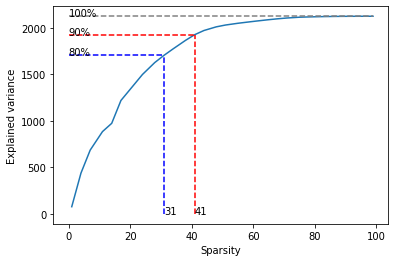

In [21]:
import matplotlib.pyplot as plt
plt.plot(px, py)
plt.xlabel('Sparsity')
plt.ylabel('Explained variance')

ind = np.where(py > 0.8 * py[num-1])[0][0]
plt.plot([0, px[ind]], [py[ind], py[ind]], 'b--')
plt.plot([px[ind], px[ind]], [0, py[ind]], 'b--')
plt.text(px[ind], 0, str(px[ind]))
plt.text(0, py[ind], '80%')

ind = np.where(py > 0.9 * py[num-1])[0][0]
plt.plot([0, px[ind]], [py[ind], py[ind]], 'r--')
plt.plot([px[ind], px[ind]], [0, py[ind]], 'r--')
plt.text(px[ind], 0, str(px[ind]))
plt.text(0, py[ind], '90%')

plt.plot([0, p], [py[num-1], py[num-1]], color='gray', linestyle='--')
plt.text(0, py[num-1],'100%')

plt.show()

This result shows that using less than half of all 99 variables can be close to perfect. For example, if we choose sparsity 31, the used variables are:

In [22]:
model = abessPCA(support_size = range(31, 32))
model.fit(X, is_normal = False)
temp = np.nonzero(model.coef_)[0]
print('non-zero position: \n', temp)

non-zero position: 
 [ 2 11 12 15 17 19 20 21 22 25 27 28 29 30 31 32 35 36 42 43 44 45 49 76
 78 79 80 81 82 83 84]


## Extension: Group abessPCA

### Group abessPCA

Furthermore, in some situation, some variables may need to consider together, that is, they should be "used" or "unused" for PC at the same time, which we call "group information". The optimization problem becomes:

$$
    \max_{v} v^{\top}\Sigma v,\qquad s.t.\quad v^Tv=1,\ \sum_{g=1}^G I(||v_g||\neq 0)\leq s.
$$

where we suppose there are $G$ groups, and the $g$-th one correspond to $v_g$, $v = [v_1^{\top},v_2^{\top},\cdots,v_G^{\top}]^{\top}$. Then we are interested to find $s$ (or less) important groups.

> Group problem is extraordinary important in real data analysis. Still take gene analysis as an example, several sites would be related to one charcter, and it is meaningless to consider each of them alone. 

abessPCA can also deal with group information. Here we make sure that variables in the same group address close to each other (if not, the data should be sorted first).

### Simulated Data Example

Suppose that the data above have group information like:

- Group 0: {the 1st, 2nd, ..., 6th variable};
- Group 1: {the 7th, 8th, ..., 12th variable};
- ...
- Group 15: {the 91st, 92nd, ..., 96th variable};
- Group 16: {the 97th, 98th, 99th variables}.

Denote different groups as different number:  

In [23]:
g_info = np.arange(17) 
g_info = g_info.repeat(6)
g_info = g_info[0:99]

print(g_info)

[ 0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3
  4  4  4  4  4  4  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  7  7  7
  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11
 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14 15 15 15 15 15 15
 16 16 16]


And fit a group sparse PCA model with additional argument `group=g_info`:

In [24]:
model = abessPCA(support_size = range(0, 7))
model.fit(X, group = g_info, is_normal = False) 

abessPCA(support_size=range(0, 7))

The result comes to:

In [25]:
print(model.coef_)

temp = np.nonzero(model.coef_)[0]
temp = np.unique(g_info[temp])

print('non-zero group: \n', temp)
print('chosen sparsity: ', temp.size)



[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.23321321  0.13263833 -0.00883629  0.17248289 -0.08871029 -0.19985191
 -0.01234905  0.22352067  0.20397847  0.18461494  0.13503884  0.05770095
  0.10299916  0.13919394 -0.03788232 -0.21903893 -0.17686649 -0.19091236
  0.18680908 -0.17823102  0.13772038 -0.03795035  0.0244231  -0.17071081
  0.          0.          0.          0.          0.          0.
  0.18057552  0.18633307  0.20310526  0.14529565 -0.01828599  0.00674497
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.21893701  0.22412321  0.22527714  0.21978957  0.21562905  0.25551422
  0.          0.          0.          0.  

Hence we can focus on variables in Group 2,3,4,5,7,13.

## Extension: Multiple principal components

### Multiple principal components

In some cases, we may seek for more than one principal components under sparsity. Actually, we can iteratively solve the largest principal component and then mapping the covariance matrix to its orthogonal space:

$$
\Sigma' = (1-vv^{\top})\Sigma(1-vv^{\top})
$$

where $\Sigma$ is the currect covariance matrix and $v$ is its (sparse) principal component. We map it into $\Sigma'$, which indicates the orthogonal space of $v$, and then solve the sparse principal component again. 

By this iteration process, we can acquire multiple principal components and they are sorted from the largest to the smallest.
In our program, there is an additional argument `number`, which indicates the number of principal components we need, defaulted by 1.


In [26]:
model = abessPCA(support_size = range(31, 32))
model.fit(X, is_normal = False, number = 3)
model.coef_.shape

(99, 3)

Here, each column of the `model.coef_` is a sparse PC (from the largest to the smallest), for example the second one is that:

In [27]:
model.coef_[:,1]

array([ 0.        ,  0.        ,  0.        , -0.19188577,  0.1547922 ,
        0.22611506,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.15955629,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.10529884,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.11801854,
        0.        ,  0.        ,  0.11530736,  0.12329678,  0.13219045,
        0.2743021 ,  0.27986763,  0.28159992,  0.28064823, -0.24725512,
        0.24598377,  0.17587584,  0.15715806,  0.        ,  0.        ,
        0.12271662, -0.13857677,  0.22541897,  0.11248632, -0.14

If we want to compute the explained variance of them, it is also quite easy: 

In [28]:
Xv = Xc.dot(model.coef_)
explained = np.sum(np.diag(Xv.T.dot(Xv)))
print( 'explained ratio: ', explained / total )

explained ratio:  0.4539961985579322


## R tutorial

For R tutorial, please view [https://abess-team.github.io/abess/articles/v08-sPCA.html](https://abess-team.github.io/abess/articles/v08-sPCA.html).